In [ ]:
#7/8/2025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Image Processing**

Load Image Paths and Labels

In [ ]:
import os
from glob import glob
import numpy as np

def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []
    supported_extensions = ['*.jpg', '*.jpeg', '*.png']

    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
          for ext in supported_extensions:
            for img_path in glob(os.path.join(class_dir, ext)):
                image_paths.append(img_path)
                labels.append(label)
    return image_paths, labels

In [ ]:
import cv2

def create_shape_mask(img_bgr):

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Define a wide range of colors to capture all the drawn shapes.
    # We are looking for any color that is not white or light gray.
    # The V channel (Value/Brightness) is key here.
    lower_bound = np.array([0, 20, 50])  # Low saturation and value
    upper_bound = np.array([179, 255, 255]) # High saturation and value

    mask = cv2.inRange(hsv, lower_bound, upper_bound)

    # Add a bit of dilation to fill in small gaps in the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    return mask

In [ ]:
def create_multi_channel_image_with_mask(image_path):

    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return None

    # Create the shape mask
    mask = create_shape_mask(img)

    # Convert to grayscale for further processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # --- Channel 1: Edges ---
    blurred_for_edges = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred_for_edges, threshold1=50, threshold2=150)

    # --- Channel 2: Texture/Pressure ---
    adaptive_thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 2
    )

    # Apply the mask to remove background texture from the channels
    edges_masked = cv2.bitwise_and(edges, edges, mask=mask)
    texture_masked = cv2.bitwise_and(adaptive_thresh, adaptive_thresh, mask=mask)

    # --- Channel 3: Grayscale (also masked for consistency) ---
    gray_masked = cv2.bitwise_and(gray, gray, mask=mask)

    # Resize and stack the channels
    desired_size = (224, 224)

    edges_resized = cv2.resize(edges_masked, desired_size)
    texture_resized = cv2.resize(texture_masked, desired_size)
    gray_resized = cv2.resize(gray_masked, desired_size)

    final_image = np.stack([edges_resized, texture_resized, gray_resized], axis=-1)

    return final_image

In [ ]:
import matplotlib.pyplot as plt

def visualize_before_after_masked(image_path):
    original_img_bgr = cv2.imread(image_path)
    if original_img_bgr is None:
        print(f"Error: Could not read original image at {image_path}")
        return

    original_img_rgb = cv2.cvtColor(original_img_bgr, cv2.COLOR_BGR2RGB)
    processed_img = create_multi_channel_image_with_mask(image_path)
    if processed_img is None:
        return

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0, 0].imshow(original_img_rgb)
    axes[0, 0].set_title('Original Image (RGB)')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(processed_img[:, :, 0], cmap='gray')
    axes[0, 1].set_title('Processed Channel 1: Masked Edges')
    axes[0, 1].axis('off')

    axes[1, 0].imshow(processed_img[:, :, 1], cmap='gray')
    axes[1, 0].set_title('Processed Channel 2: Masked Texture/Pressure')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(processed_img[:, :, 2], cmap='gray')
    axes[1, 1].set_title('Processed Channel 3: Masked Grayscale')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# --- NEW Function to load and process all images ---

def load_processed_images(image_paths):
    """
    Loads and processes a list of images using the multi-channel pipeline.
    """
    processed_images = []
    for path in image_paths:
        processed_img = create_multi_channel_image_with_mask(path)
        if processed_img is not None:
            processed_images.append(processed_img)
    return processed_images

In [ ]:
train_dir = '/content/drive/MyDrive/MP_AUTISM/Coloring/Train'
valid_dir = '/content/drive/MyDrive/MP_AUTISM/Coloring/Valid'
test_dir  = '/content/drive/MyDrive/MP_AUTISM/Coloring/Test'

train_paths, train_labels = get_image_paths_and_labels(train_dir)
valid_paths, valid_labels = get_image_paths_and_labels(valid_dir)
test_paths, test_labels = get_image_paths_and_labels(test_dir)

In [ ]:
# Process all images in the training set
processed_train_imgs = load_processed_images(train_paths)
processed_valid_imgs = load_processed_images(valid_paths)
processed_test_imgs = load_processed_images(test_paths)

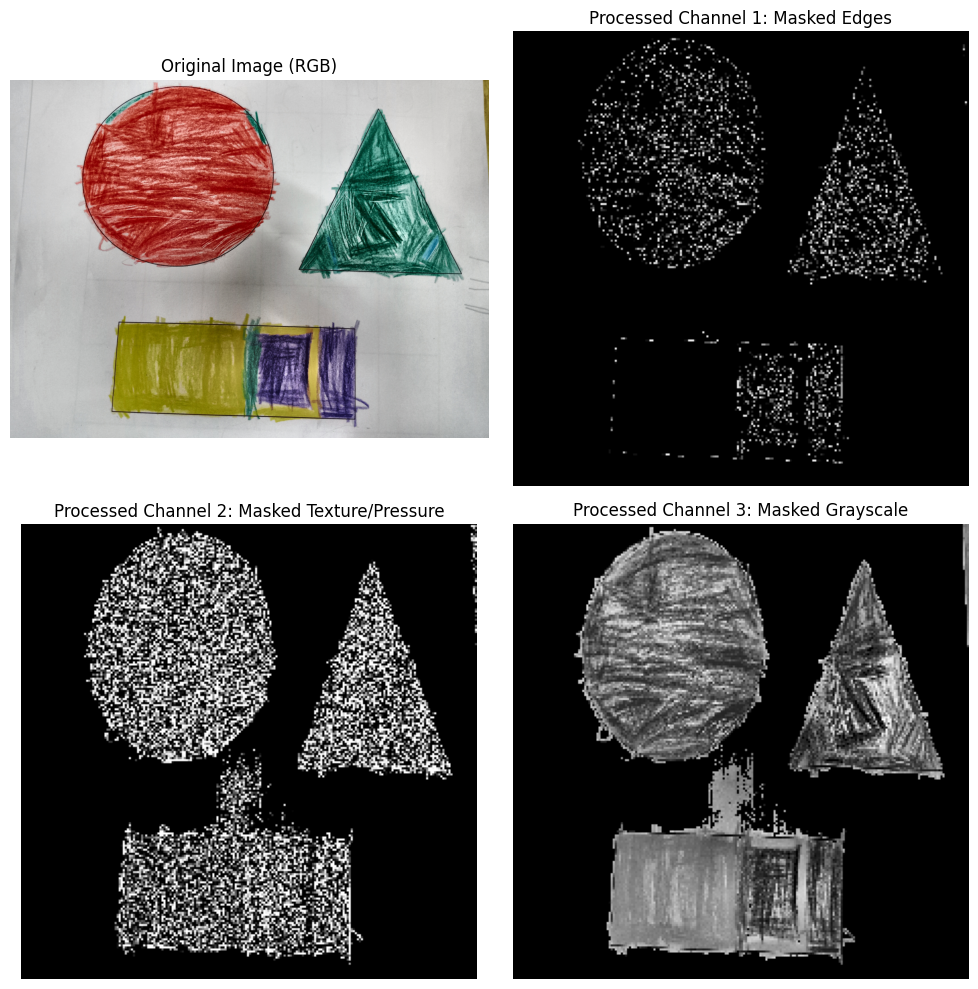

In [ ]:
train_paths, train_labels = get_image_paths_and_labels(train_dir)
if not train_paths:
    print("No images found in the training directory. Please check the path.")
else:
    image_path_to_visualize = train_paths[0] # Pick the first image
    visualize_before_after_masked(image_path_to_visualize)

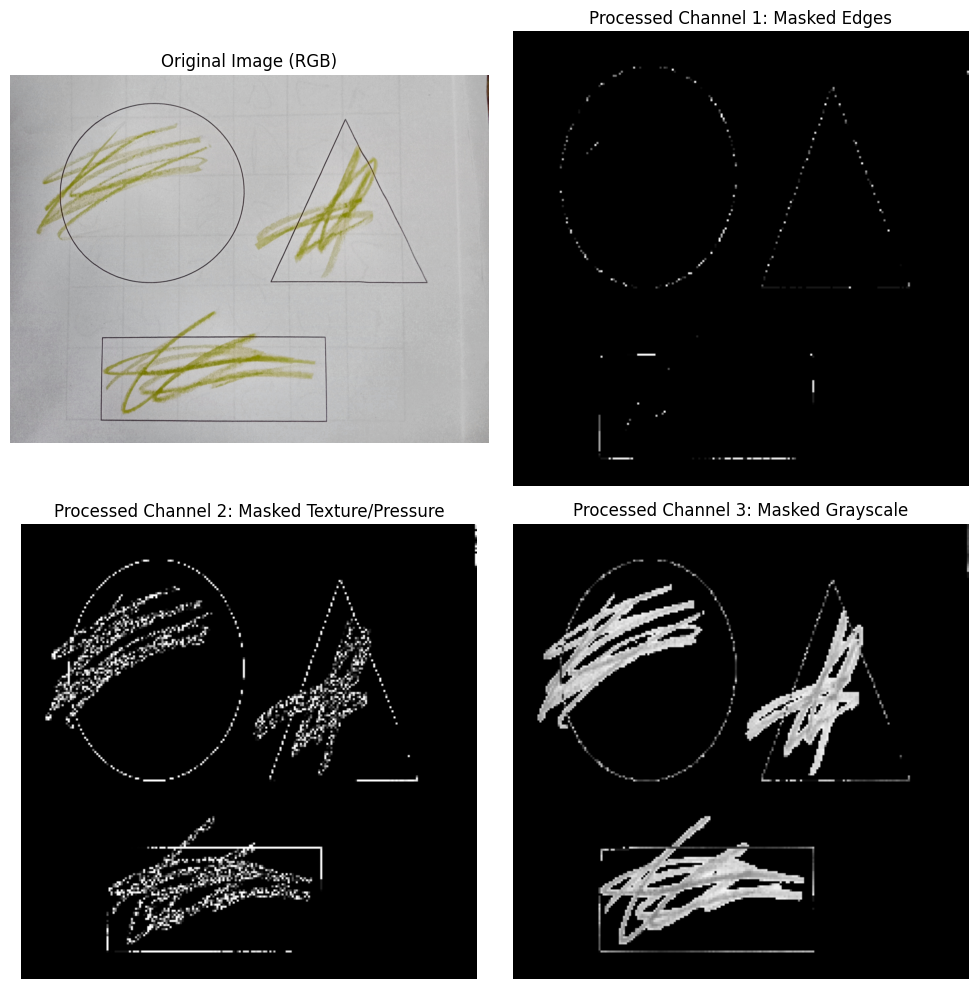

In [ ]:
train_paths, train_labels = get_image_paths_and_labels(train_dir)
if not train_paths:
    print("No images found in the training directory. Please check the path.")
else:
    image_path_to_visualize = train_paths[50] # Pick the first image
    visualize_before_after_masked(image_path_to_visualize)

In [ ]:
# --- New function to handle saving ---
def save_processed_images(image_paths, labels, output_dir):
    # Create the output directories if they don't exist
    for label in set(labels):
        os.makedirs(os.path.join(output_dir, label), exist_ok=True)

    # Process and save each image
    for path, label in zip(image_paths, labels):
        processed_img = create_multi_channel_image_with_mask(path)
        if processed_img is not None:
            # Construct the new file path
            original_filename = os.path.basename(path)
            new_path = os.path.join(output_dir, label, original_filename)

            # Save the processed 3-channel image
            npy_path = os.path.splitext(new_path)[0] + '.npy'  # change extension to .npy
            np.save(npy_path, processed_img)
            print(f"Saved: {npy_path}")

In [ ]:
output_train = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train'
output_valid = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Valid'
output_test = '/content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Test'

In [ ]:
# Save the processed images
print("Saving training images...")
save_processed_images(train_paths, train_labels, output_train)
print("\nSaving validation images...")
save_processed_images(valid_paths, valid_labels, output_valid)
print("\nSaving test images...")
save_processed_images(test_paths, test_labels, output_test)

Saving training images...
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150414.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150216.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150003.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_145831.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150616.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150151.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/cn5.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/IMG_20240329_150239.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/cn7.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Processed_Train/Non_ASD/cn8.npy
Saved: /content/drive/MyDrive/MP_AUTISM/Coloring/Pro